In [1]:
# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('ticks')

In [2]:
# munging
import os

In [22]:
# science
from starfish import IntensityTable, Experiment, ImageStack
from starfish.plot import histogram, decoded_spots, compare_copy_number
from starfish.plot.decoded_spots import decoded_spots
from starfish.types import Features, Indices
import numpy as np
import pandas as pd

from showit import image

## Load IntensityTables

In [4]:
# IntensityTable can't download from directories without list privileges

data_root = "https://dmf0bdeheu4zf.cloudfront.net/assay_comparison/"
iss_link = os.path.join(data_root, "iss.nc")
merfish_link = os.path.join(data_root, "merfish.nc")
dartfish_link = os.path.join(data_root, "dartfish.nc")

tmp = os.environ['TMPDIR']
iss_nc = os.path.join(tmp, "iss.nc")
merfish_nc = os.path.join(tmp, "merfish.nc")
dartfish_nc = os.path.join(tmp, "dartfish.nc")


!curl -o $iss_nc $iss_link
!curl -o $merfish_nc $merfish_link
!curl -o $dartfish_nc $dartfish_link

iss_intensity_table = IntensityTable.load(iss_nc)
merfish_intensity_table = IntensityTable.load(merfish_nc)
dartfish_intensity_table = IntensityTable.load(dartfish_nc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  700k  100  700k    0     0  1950k      0 --:--:-- --:--:-- --:--:-- 1949k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5450k  100 5450k    0     0  7521k      0 --:--:-- --:--:-- --:--:-- 7517k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83532  100 83532    0     0   245k      0 --:--:-- --:--:-- --:--:--  246k


In [5]:
datasets = [iss_intensity_table, merfish_intensity_table, dartfish_intensity_table]

## Load Background Images

In [6]:
# construct background images for each assay
stack = Experiment.from_json(
    'https://dmf0bdeheu4zf.cloudfront.net/20180821/DARTFISH/fov_001/experiment.json'
)

dartfish_nuclei = stack.auxiliary_images['nuclei'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)
dartfish_link = os.path.join(data_root, "dartfish_dots_image.npy")
dartfish_npy = os.path.join(tmp, "dartfish.npy")
!curl -o $dartfish_npy $dartfish_link
dartfish_dots = np.load(dartfish_npy)

100%|██████████| 1/1 [00:00<00:00, 68.20it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 7626k  100 7626k    0     0  3918k      0  0:00:01  0:00:01 --:--:-- 3916k


In [7]:
stack = Experiment.from_json(
    'https://dmf0bdeheu4zf.cloudfront.net/20180821/ISS/fov_001/experiment.json'
)

iss_nuclei = stack.auxiliary_images['nuclei'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)
iss_dots = stack.auxiliary_images['dots'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)

100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


In [8]:
stack = Experiment.from_json(
    'https://dmf0bdeheu4zf.cloudfront.net/20180802/MERFISH/fov_001/experiment.json'
)
merfish_nuclei = stack.auxiliary_images['nuclei'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)

# merfish doesn't have a dots image, and some of the channels are stronger than others.
# We can use the scale factors to get the right levels
merfish_background = stack.image.max_proj(Indices.CH, Indices.ROUND)
merfish_background = np.reshape(merfish_background, (1, 1, *merfish_background.shape))
merfish_background = ImageStack.from_numpy_array(merfish_background)

from starfish.image import Filter
clip = Filter.Clip(p_max=99.7)
merfish_dots = clip.run(merfish_background, in_place=False)

merfish_dots = merfish_dots.max_proj(Indices.CH, Indices.ROUND, Indices.Z)

100%|██████████| 1/1 [00:00<00:00, 2739.58it/s]


## Load Decoded Images

Numpy load can't download files from s3 either.

In [9]:
merfish_link = os.path.join(data_root, "merfish_decoded_image.npy")
dartfish_link = os.path.join(data_root, "dartfish_decoded_image.npy")

merfish_npy = os.path.join(tmp, "merfish_decoded_image.npy")
dartfish_npy = os.path.join(tmp, "dartfish_decoded_image.npy")


!curl -o $merfish_npy $merfish_link
!curl -o $dartfish_npy $dartfish_link


merfish_decoded_image = np.squeeze(np.load(merfish_npy))
dartfish_decoded_image = np.squeeze(np.load(dartfish_npy))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.0M  100 32.0M    0     0  7102k      0  0:00:04  0:00:04 --:--:-- 7437k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7626k  100 7626k    0     0  7558k      0  0:00:01  0:00:01 --:--:-- 7565k


## Show Different Background Types for MERFISH

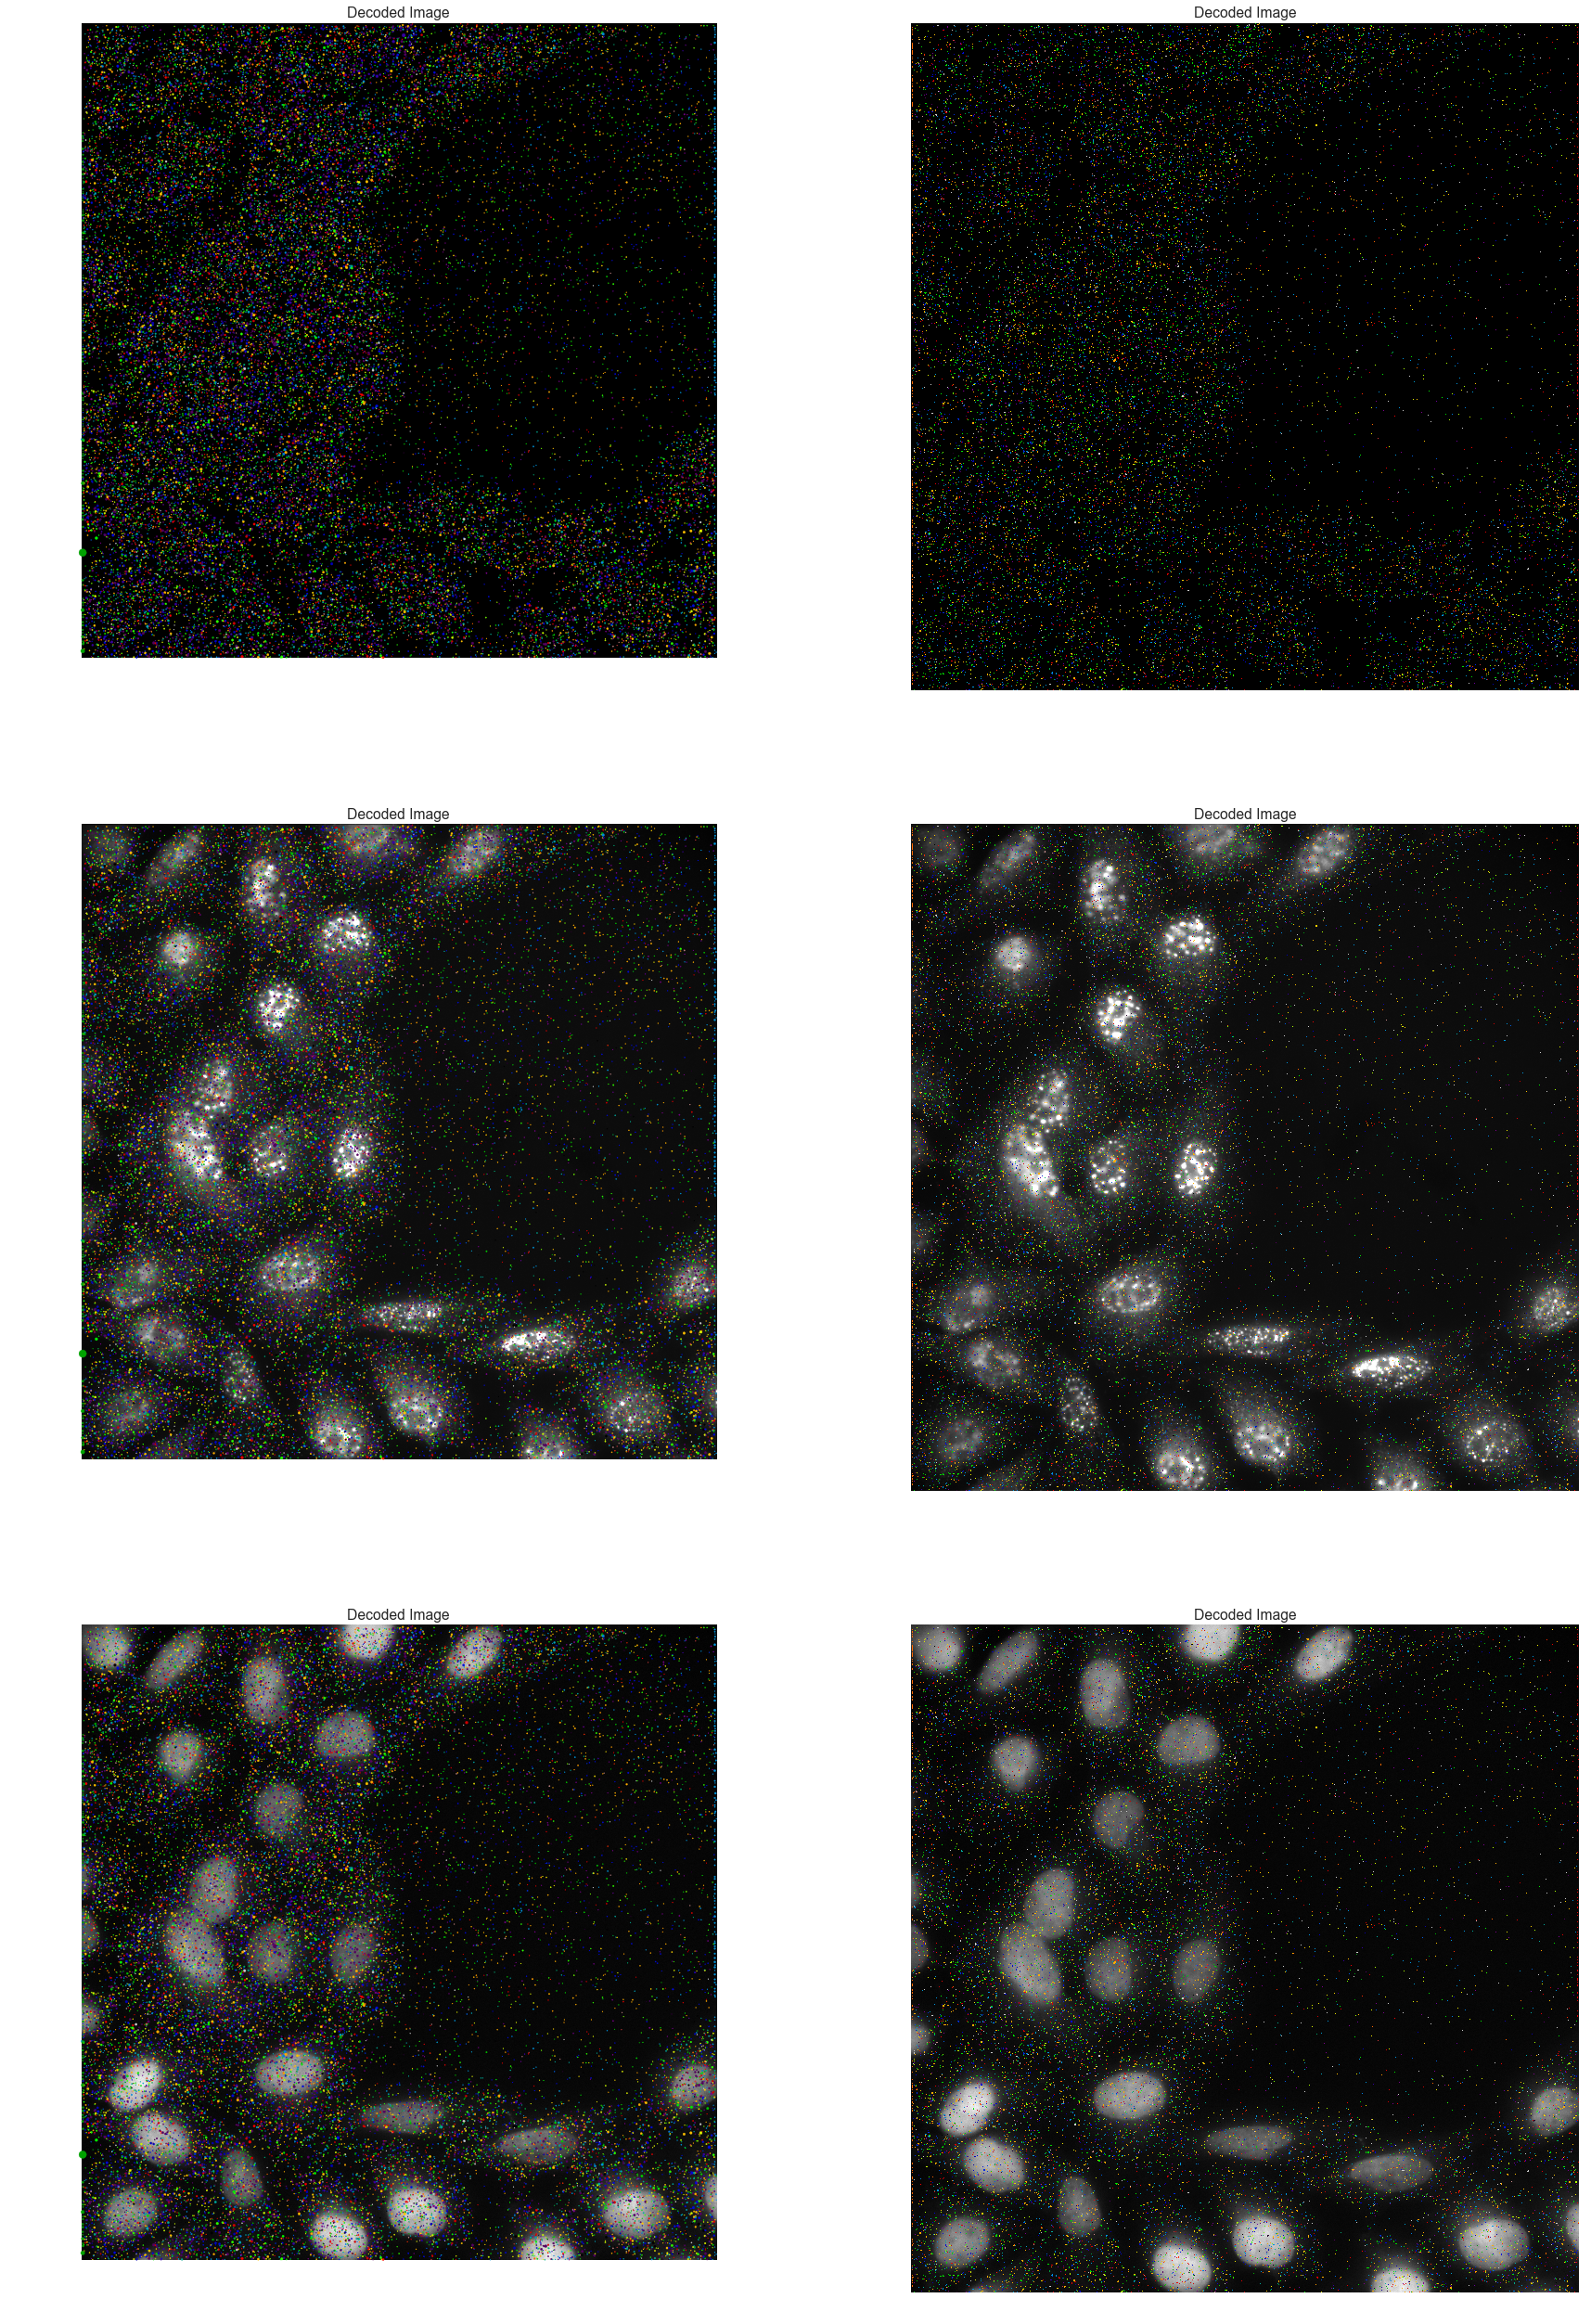

In [10]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(30, 45))
decoded_spots(
    merfish_intensity_table,
    background_image=np.zeros_like(merfish_dots),
    spots_kwargs=dict(alpha=1.),
    ax=ax1
)
decoded_spots(
    merfish_intensity_table,
    background_image=merfish_dots,
    spots_kwargs=dict(alpha=1.),
    ax=ax3
)
decoded_spots(
    merfish_intensity_table,
    background_image=merfish_nuclei,
    spots_kwargs=dict(alpha=1.),
    ax=ax5
)
decoded_spots(
    decoded_image=merfish_decoded_image,
    decoded_image_kwargs=dict(alpha=1.),
    ax=ax2
)
decoded_spots(
    decoded_image=merfish_decoded_image,
    background_image=merfish_dots,
    decoded_image_kwargs=dict(alpha=1.),
    ax=ax4
)
decoded_spots(
    decoded_image=merfish_decoded_image,
    background_image=merfish_nuclei,
    decoded_image_kwargs=dict(alpha=1.),
    ax=ax6
);

From these examples, we can see that the point cloud over-estimates the spot size
(perhaps we're calculating radius wrong?)

## Show different background types for DARTFISH

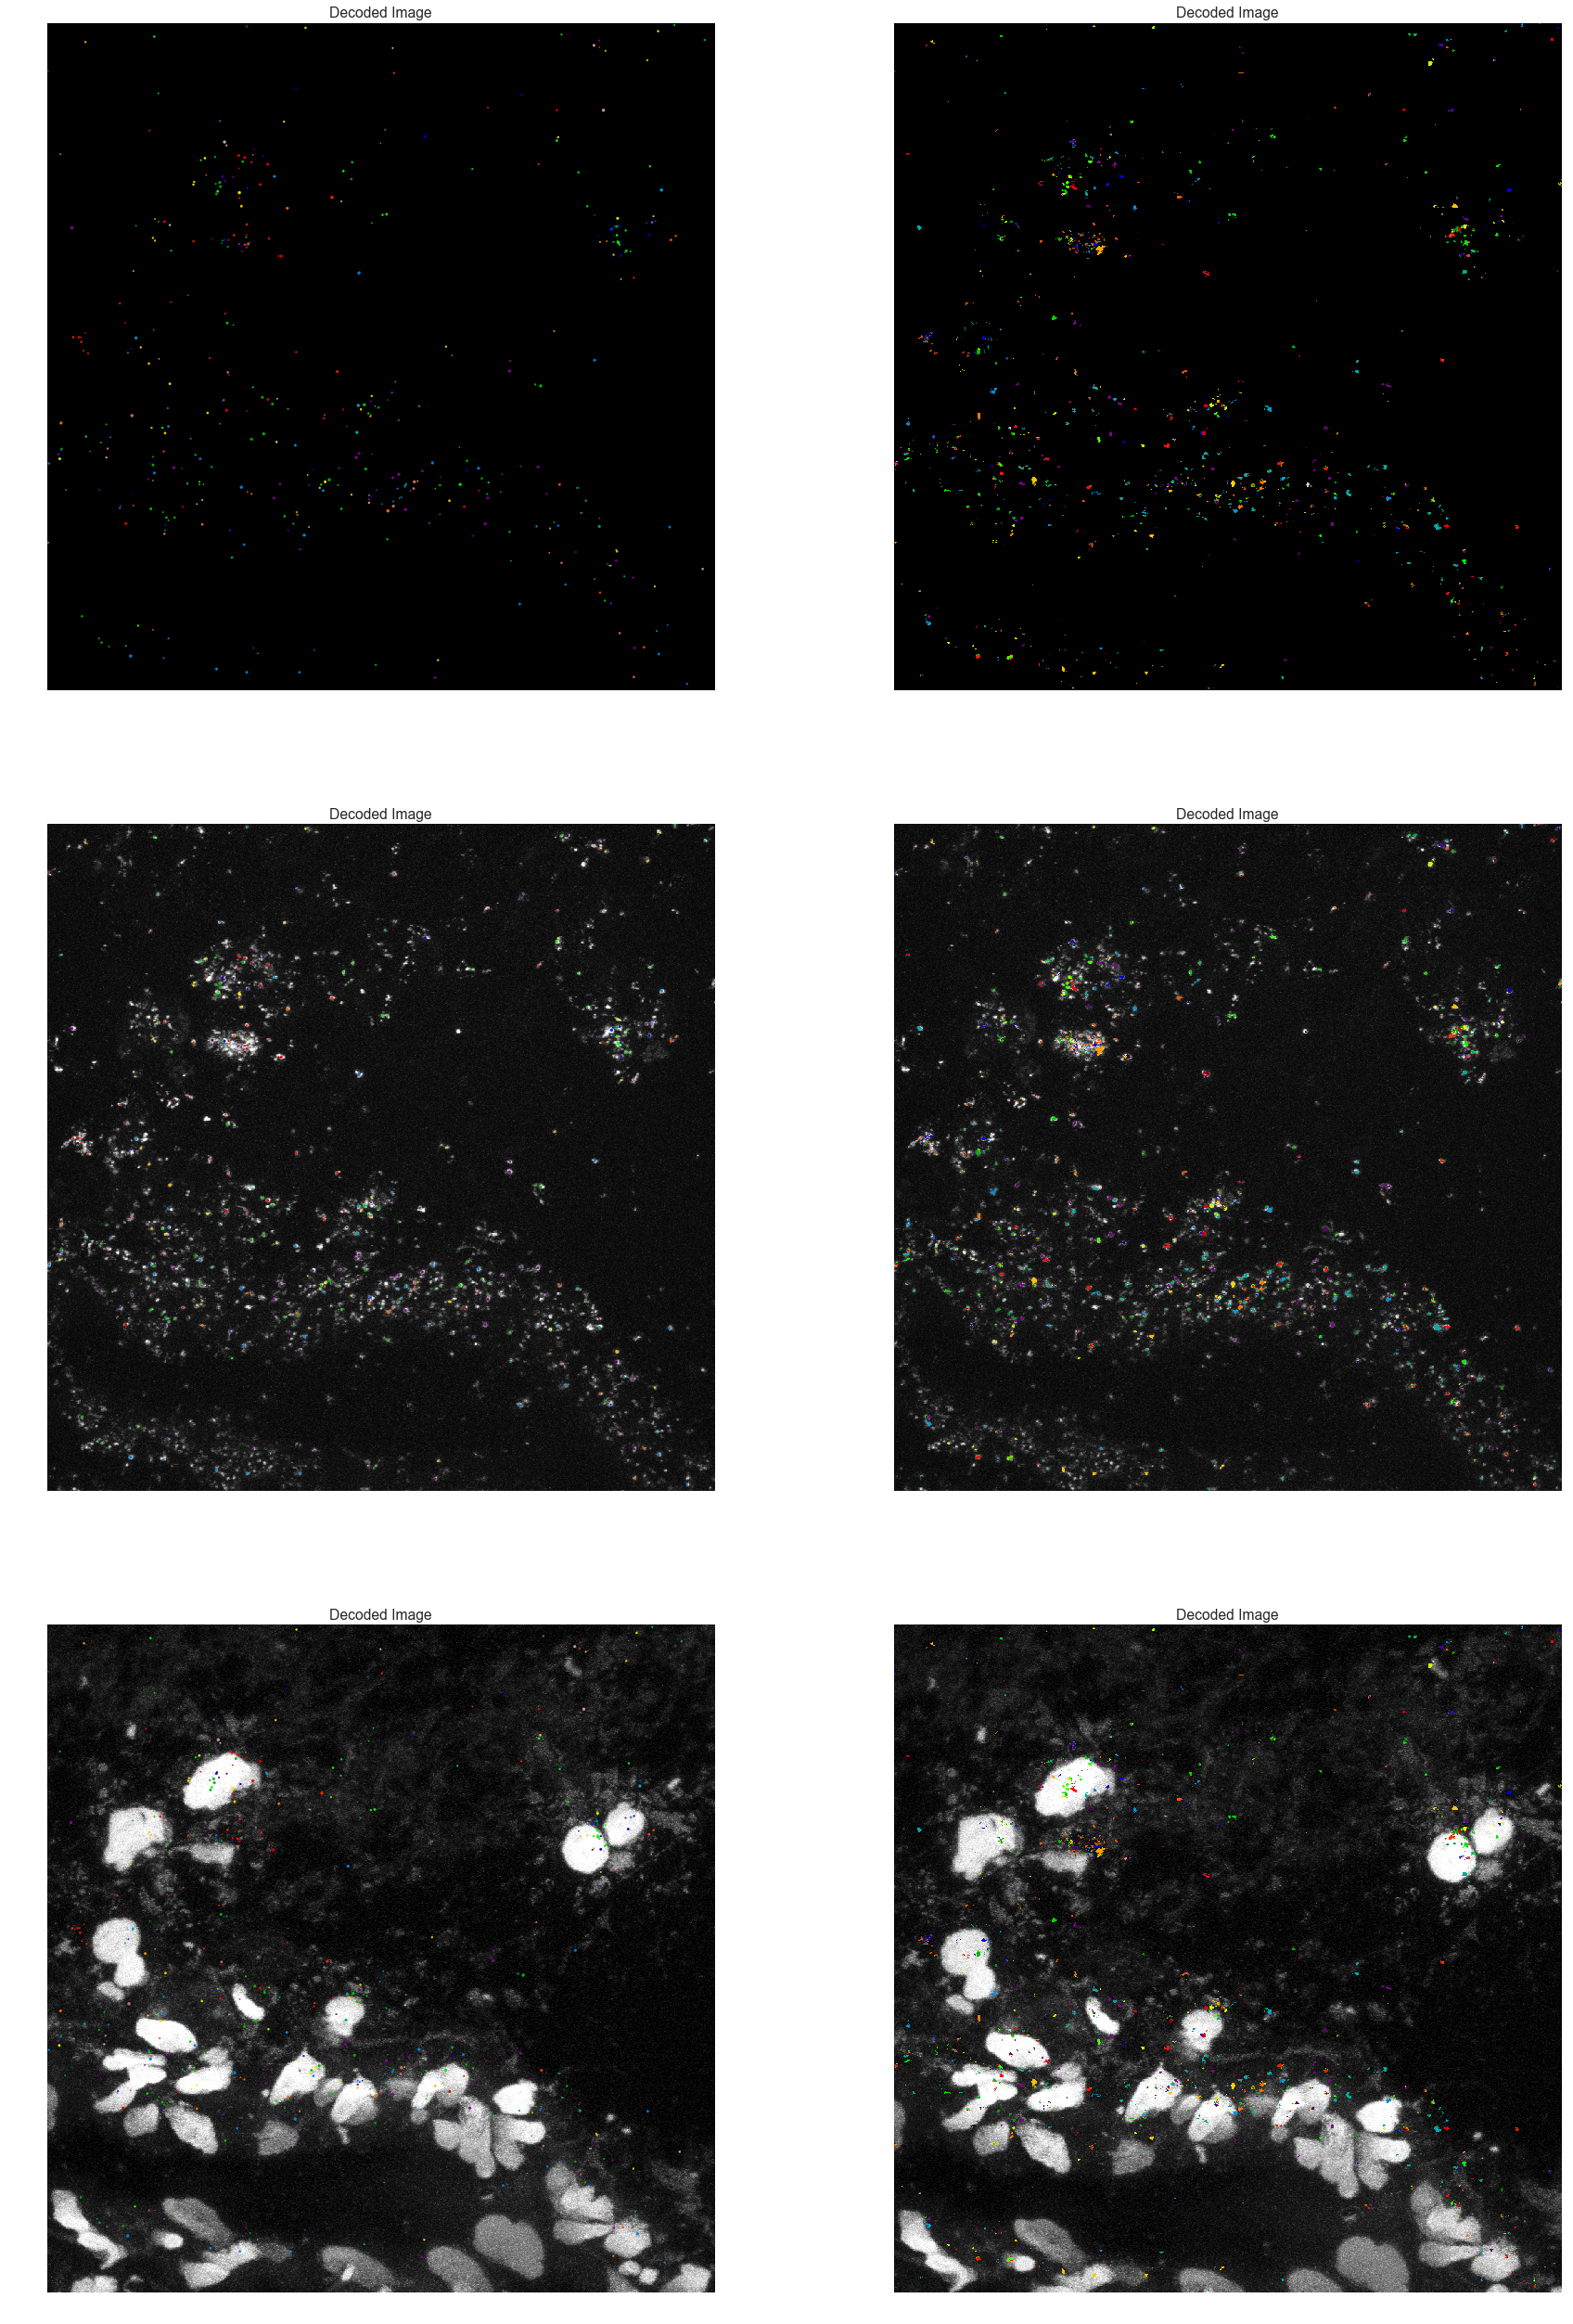

In [11]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(30, 45))
decoded_spots(
    dartfish_intensity_table,
    background_image=np.zeros_like(dartfish_dots),
    spots_kwargs=dict(alpha=1.),
    ax=ax1
)
decoded_spots(
    dartfish_intensity_table,
    background_image=dartfish_dots,
    spots_kwargs=dict(alpha=1.),
    ax=ax3
)
decoded_spots(
    dartfish_intensity_table,
    background_image=dartfish_nuclei,
    spots_kwargs=dict(alpha=1.),
    ax=ax5
)
decoded_spots(
    decoded_image=dartfish_decoded_image,
    decoded_image_kwargs=dict(alpha=1.),
    ax=ax2
)
decoded_spots(
    decoded_image=dartfish_decoded_image,
    background_image=dartfish_dots,
    decoded_image_kwargs=dict(alpha=1.),
    ax=ax4
)
decoded_spots(
    decoded_image=dartfish_decoded_image,
    background_image=dartfish_nuclei,
    decoded_image_kwargs=dict(alpha=1.),
    ax=ax6
);

## Show different background types for ISS

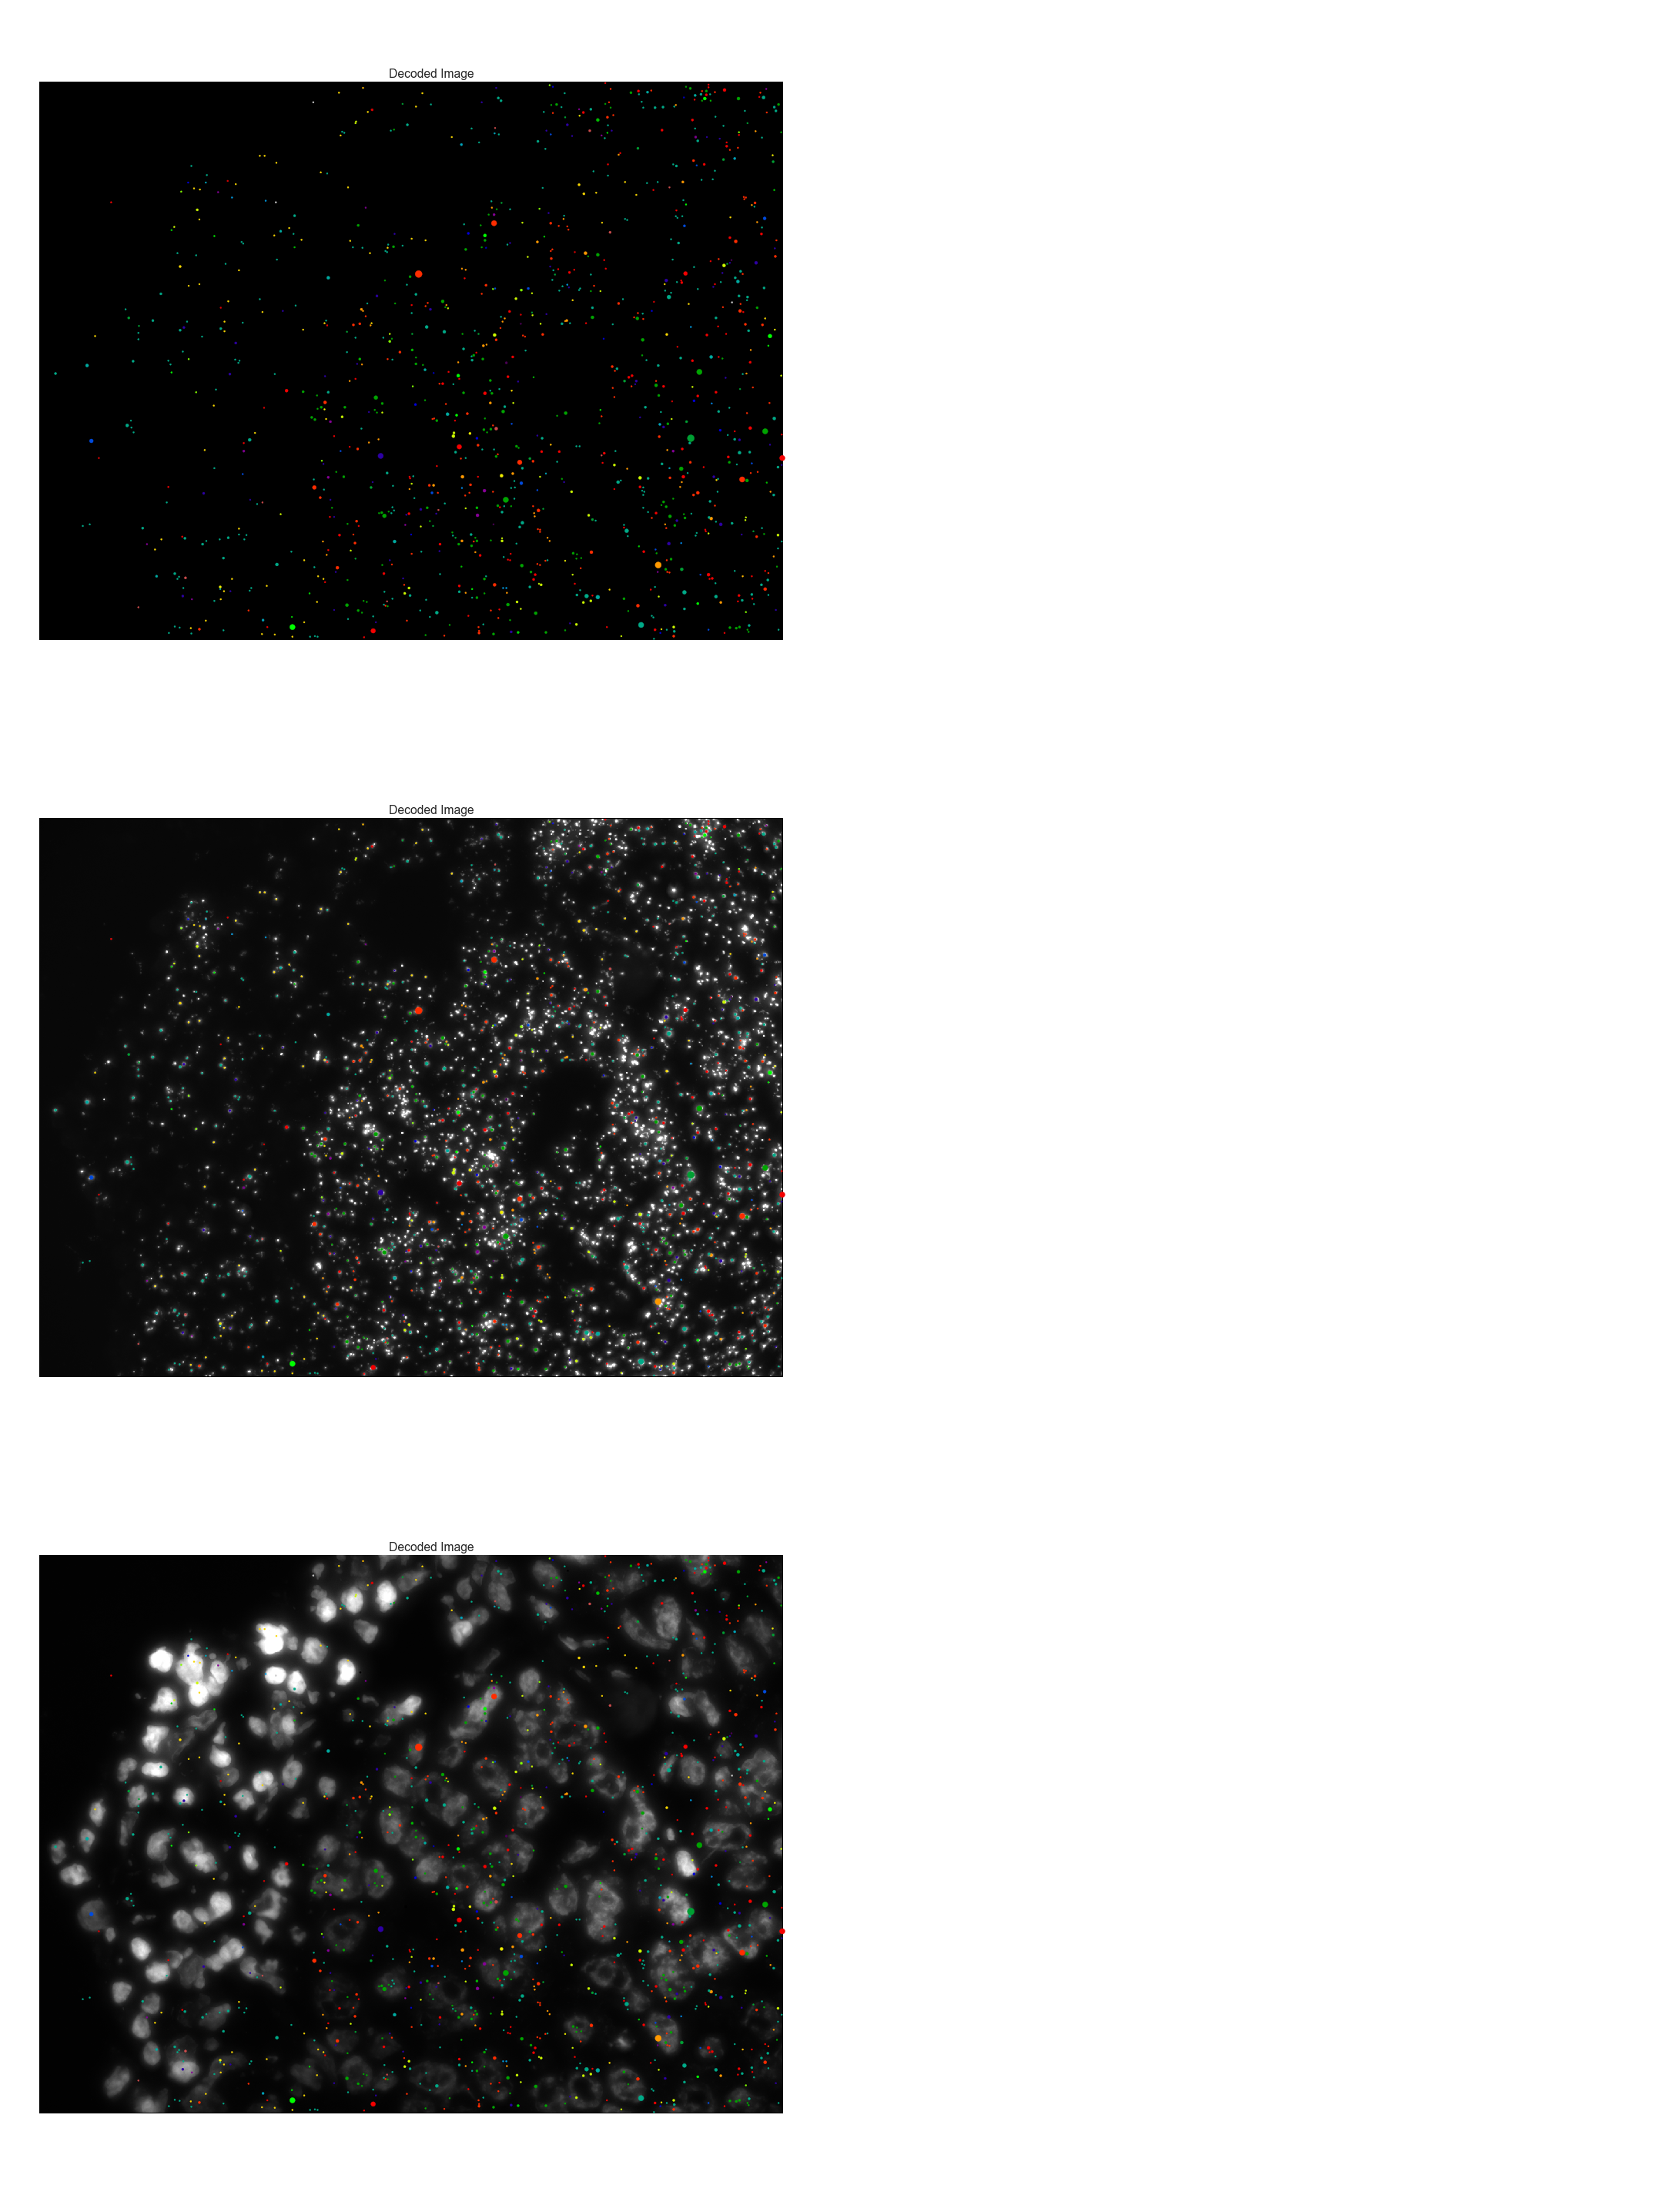

In [12]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(30, 40))
decoded_spots(
    iss_intensity_table,
    background_image=np.zeros_like(iss_dots),
    spots_kwargs=dict(alpha=1.),
    ax=ax1
)
decoded_spots(
    iss_intensity_table,
    background_image=iss_dots,
    spots_kwargs=dict(alpha=1.),
    ax=ax3
)
decoded_spots(
    iss_intensity_table,
    background_image=iss_nuclei,
    spots_kwargs=dict(alpha=1.),
    ax=ax5
)

# ISS doesn't have a decoded image right now, but we can make one! Leave the placeholders open. 
for ax in (ax2, ax4, ax6):
    ax.set_axis_off()
f.tight_layout()

## Download available copy number information from assay authors

In [13]:
dartfish_copy_number = pd.read_csv(
    'https://dmf0bdeheu4zf.cloudfront.net/20180821/DARTFISH/fov_001/counts.csv',
    index_col=0,
    squeeze=True
)
merfish_copy_number = pd.read_csv(
    os.path.join(data_root, "merfish_copy_number_benchmark.csv"),
    index_col=0,
    squeeze=True
)
iss_copy_number = pd.read_csv(
    os.path.join(data_root, "iss_copy_number_benchmark.csv"),
    index_col=1
)['cnt']

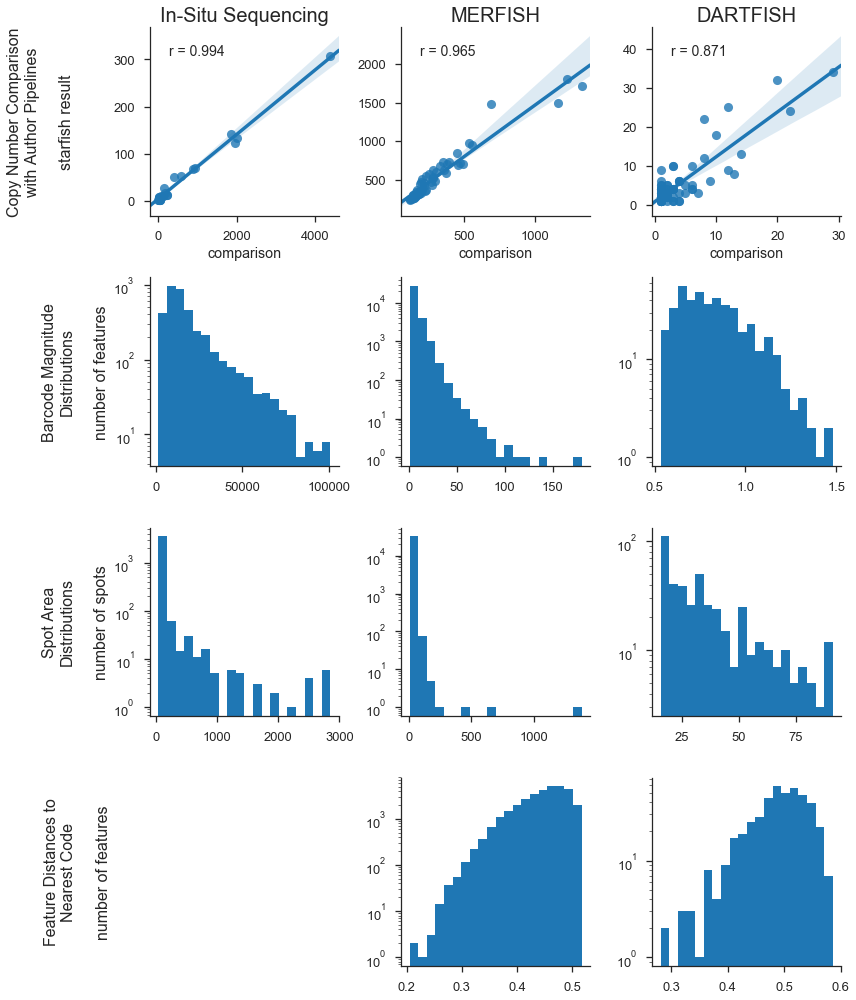

In [26]:
f, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 14))
iterable = zip(
    [iss_intensity_table, merfish_intensity_table, dartfish_intensity_table],
    [iss_copy_number, merfish_copy_number, dartfish_copy_number],
    axes[0, :]
)
for dataset, benchmark, axis in iterable:
    compare_copy_number(dataset, benchmark, ax=axis, color='tab:blue')

for dataset, axis in zip(datasets, axes[1, :]):
    norms = dataset.feature_trace_magnitudes()
    histogram(norms, bins=20, log=True, ax=axis)

for dataset, axis in zip(datasets, axes[2, :]):
    area = (dataset.radius * np.pi) ** 2
    histogram(area, bins=20, ax=axis)

for dataset, axis in zip([merfish_intensity_table, dartfish_intensity_table], axes[3, 1:]):
    distances = dataset[Features.DISTANCE].values
    histogram(distances, bins=20, ax=axis)

# set the assay names as the titles of the top plots
axes[0, 0].set_title('In-Situ Sequencing', fontsize=20)
axes[0, 1].set_title('MERFISH', fontsize=20)
axes[0, 2].set_title('DARTFISH', fontsize=20);

# reset y-axis labels
for ax in np.ravel(axes):
    ax.set_ylabel('')
    
# reset titles
for ax in np.ravel(axes[1:, :]):
    ax.set_title('')

# set the y-axis labels
column_1_axes = (axes[:, 0])
plot_names = (
    'Copy Number Comparison\nwith Author Pipelines\n\nstarfish result\n\n',
    'Barcode Magnitude\nDistributions\n\nnumber of features',
    'Spot Area\nDistributions\n\nnumber of spots',
    'Feature Distances to\nNearest Code\n\nnumber of features\n\n'
)
for ax, name in zip(column_1_axes, plot_names):
    ax.set_ylabel(name, fontsize=16)


# fix up the figure
f.tight_layout()
for ax in np.ravel(axes):
    sns.despine(ax=ax)

# turn off the empty plot, matplotlib is super bad about this.
for ax in (axes[3, 0],):
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    # remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)

The histogram can be used to demonstrate parameter thresholding, as well. 

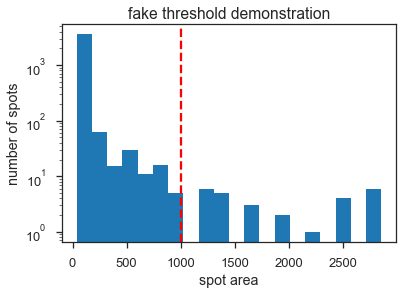

In [33]:
f, ax = plt.subplots()
area = (iss_intensity_table.radius * np.pi) ** 2
histogram(
    area, 
    bins=20, 
    threshold=1000, 
    title='fake threshold demonstration', 
    ylabel='number of spots', 
    xlabel='spot area'
);